<a href="https://colab.research.google.com/github/nihal-rao/detectron2_experiments/blob/master/Hand_Faster_RCNN_R101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 40kB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 36.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=a8490e3db610fae934b1e7bb9bfbbbdd89a8028fe49e9b874f7fffd405e00555
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3aqhtl75
  Running command git c

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 2.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200325-cp36-none-any.whl size=38930 sha256=6c9a070bdbc9792aaa89690c88966024d588e745b3a6e776f53acd7c0bf25de1
  Stored in directory: /root/.cache/pip/wheels/58/4f/d1/6b0ada294145df5fe73092d9849d27be5b5b720fd8cfdd1b98
Successfully built fvcore


In [0]:
import numpy as np
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from detectron2.data.datasets import register_coco_instances
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

register_coco_instances("ego_train", {}, "/content/drive/My Drive/egohands/instances_hands_train2020.json", "/content/drive/My Drive/egohands/train_images")
register_coco_instances("ego_val", {}, "/content/drive/My Drive/egohands/instances_hands_test2020.json", "/content/drive/My Drive/egohands/test_images")

train_metadata = MetadataCatalog.get("ego_train")
val_metadata = MetadataCatalog.get("ego_val")


[03/21 04:03:05 d2.data.datasets.coco]: Loaded 600 images in COCO format from /content/drive/My Drive/egohands/instances_hands_test2020.json


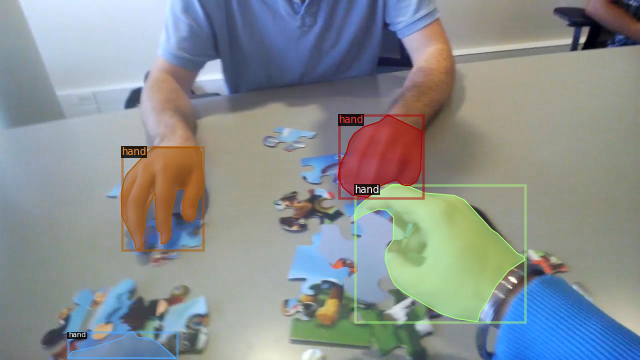

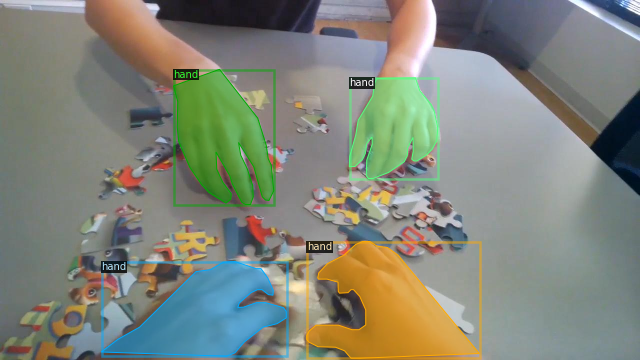

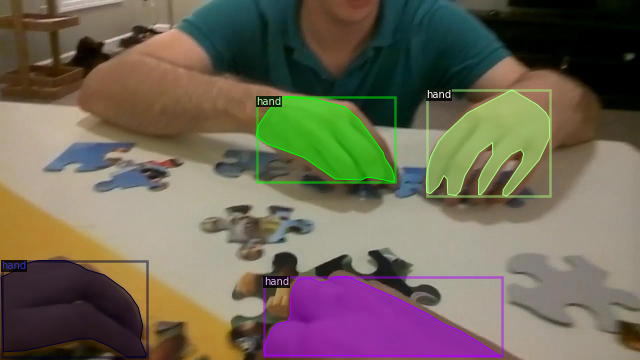

In [0]:
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("ego_val")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training


In [0]:
import torch 
import detectron2.utils.comm as comm

class ValidationLoss(detectron2.engine.HookBase):
    def __init__(self, config):
        super(ValidationLoss, self).__init__()
        self.cfg = config.clone()
        self.cfg.DATASETS.TRAIN = config.DATASETS.VAL
        self._loader = iter(detectron2.data.build_detection_train_loader(self.cfg))

    def after_step(self):
      batch =  next(self._loader) 
      with torch.no_grad():
        loss_dict = self.trainer.model(batch)
        loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
          self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)     


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ego_train",)
cfg.DATASETS.VAL = ("ego_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
"""
cfg.SOLVER.BASE_LR = 0.0025  
cfg.SOLVER.MAX_ITER =     # For better results change to 5000 
"""

cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.STEPS = (500,1000,)
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 10
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 128 images per batch
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

[03/26 14:15:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:04, 56.9MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[03/26 14:15:37 d2.engine.train_loop]: Starting training from iteration 0
[03/26 14:16:11 d2.utils.events]:  eta: 0:00:00  iter: 19  total_loss: 1.347  loss_cls: 0.517  loss_box_reg: 0.832  loss_rpn_cls: 0.035  loss_rpn_loc: 0.016  total_val_loss: 1.417  val_loss_cls: 0.509  val_loss_box_reg: 0.884  val_loss_rpn_cls: 0.038  val_loss_rpn_loc: 0.018  time: 0.6762  data_time: 0.0348  lr: 0.001000  max_mem: 3771M
[03/26 14:16:11 d2.engine.hooks]: Overall training speed: 17 iterations in 0:00:12 (0.7160 s / it)
[03/26 14:16:11 d2.engine.hooks]: Total training time: 0:00:31 (0:00:19 on hooks)


In [0]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output

## Evaluation using the trained model


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

#cfg.MODEL.WEIGHTS = os.path.join('/content/output', "model_final.pth")
cfg.MODEL.WEIGHTS ='/content/drive/My Drive/hand_rcnn_101/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   #set the testing threshold for this model
cfg.DATASETS.TEST = ("ego_val", )
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
predictor = DefaultPredictor(cfg)


[03/26 14:16:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

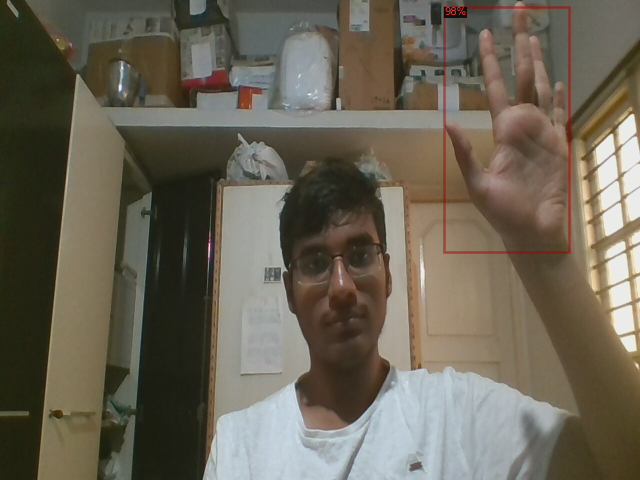

(480, 640, 3)
0.20471596717834473


In [0]:
im = cv2.imread('/content/drive/My Drive/hand_op2/3.jpg')
st = time.time()
outputs = predictor(im)
end = time.time()
v = Visualizer(im[:, :, ::-1],
                   metadata=rpc_val_metadata, 
                   scale=0.5, 
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
n=v.get_image()[:, :, ::-1]
print(n.shape)
print(end-st)

[03/24 08:44:03 d2.data.datasets.coco]: Loaded 600 images in COCO format from /content/drive/My Drive/egohands/instances_hands_test2020.json
/content/drive/My Drive/egohands/test_images/1551.jpg


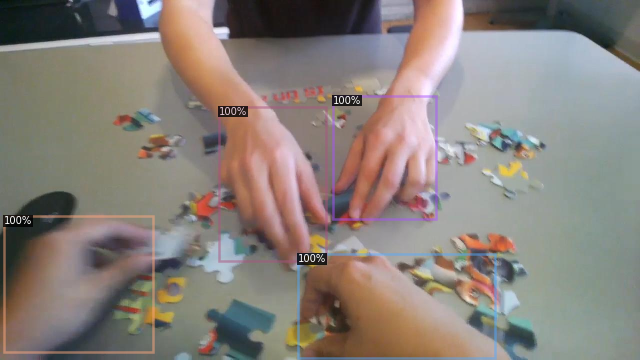

/content/drive/My Drive/egohands/test_images/1575.jpg


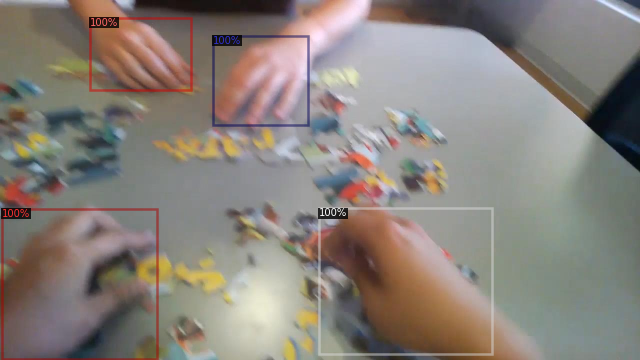

/content/drive/My Drive/egohands/test_images/1573.jpg


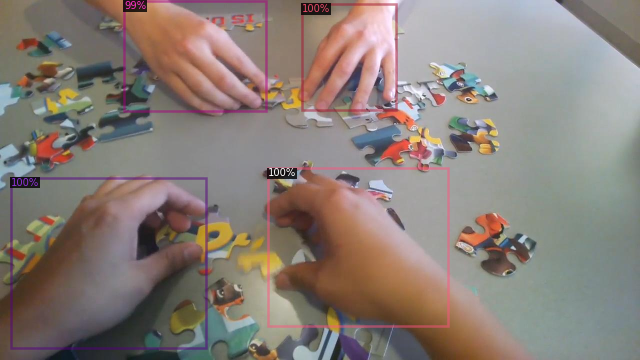

In [0]:
import torch

dataset_dicts = DatasetCatalog.get("ego_val")
# Visualizing detections in images randomly sampled from the test set  
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(d["file_name"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=rpc_val_metadata, 
                   scale=0.5, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    #print(create_list(items))
    #print_bill(items)

In [0]:
import shutil
shutil.copytree('/content/output', '/content/drive/My Drive/hand_rcnn_101')

'/content/drive/My Drive/hand_op2'

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ego_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ego_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[03/24 08:44:33 d2.data.datasets.coco]: Loaded 600 images in COCO format from /content/drive/My Drive/egohands/instances_hands_test2020.json
[03/24 08:44:34 d2.data.common]: Serializing 600 elements to byte tensors and concatenating them all ...
[03/24 08:44:34 d2.data.common]: Serialized dataset takes 1.29 MiB
[03/24 08:44:34 d2.evaluation.evaluator]: Start inference on 600 images
[03/24 08:44:35 d2.evaluation.evaluator]: Inference done 11/600. 0.1007 s / img. ETA=0:01:00
[03/24 08:44:40 d2.evaluation.evaluator]: Inference done 60/600. 0.1009 s / img. ETA=0:00:55
[03/24 08:44:45 d2.evaluation.evaluator]: Inference done 109/600. 0.1009 s / img. ETA=0:00:50
[03/24 08:44:50 d2.evaluation.evaluator]: Inference done 158/600. 0.1009 s / img. ETA=0:00:45
[03/24 08:44:55 d2.evaluation.evaluator]: Inference done 207/600. 0.1011 s / img. ETA=0:00:40
[03/24 08:45:00 d2.evaluation.evaluator]: Inference done 256/600. 0.1012 s / img. ETA=0:00:35
[03/24 08:45:05 d2.evaluation.evaluator]: Inference d

OrderedDict([('bbox',
              {'AP': 72.08353315470465,
               'AP50': 96.86766553632064,
               'AP75': 88.29873616655395,
               'APl': 73.9794449175294,
               'APm': 50.503176232652855,
               'APs': 17.584158415841582})])